In [1]:
import esm
import torch
from Bio.PDB import PDBParser, PPBuilder
from Bio import SeqIO
from abnumber import Chain
import time
#import gc
import os
#import csv 
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn

%run "../scripts/data_processing.py"
%run "../scripts/node_edge_generation.py"
%run "../scripts/graph_functions.py"
%run "../scripts/vcf_genomics_functions.py"
%run "../scripts/pytorch_functions.py"
    
#Data path
datadir = os.path.abspath("../../Data/")

In [198]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

def loadEmbd(dataframe, outfold, sumdf):
    embdic= {}
    for i, row in dataframe.iterrows():
        #print(f'{row["pdb_id"]} {sumdf.loc[sumdf["pdb"] == row["pdb_id"]]["affinity"].values[0]}')
        #print(f'{outfold}{row["pdb_id"]}_vh.pt, {row["pdb_id"]}_vl.pt, {row["pdb_id"]}_ag.pt,')
        gc.collect()
        torch.cuda.empty_cache()
        embd_vh = torch.load(f'{outfold}{row["pdb_id"]}_vh.pt')
        embd_vl = torch.load(f'{outfold}{row["pdb_id"]}_vl.pt')
        embd_ag = torch.load(f'{outfold}{row["pdb_id"]}_ag.pt')
        if "affin" in sumdf:
            #display(sumdf)
            affin = sumdf.loc[sumdf["pdb_id"] == row["pdb_id"]]["affin"].values[0]
        else:
            affin = sumdf.loc[sumdf["pdb"] == row["pdb_id"]]["affinity"].values[0]
        #break
        if np.isnan(affin) == False:
            #print(affin, np.isnan(affin))
            embdic.setdefault(row["pdb_id"], [embd_vh, embd_vl, embd_ag, affin])

    return embdic

def preprocess_dict(raw_dict):
    processed = {}
    for pdb_id, (vh, vl, ag, aff) in raw_dict.items():
        vh = vh.squeeze(0)  # remove batch dim → (L_vh, d)
        vl = vl.squeeze(0)
        ag = ag.squeeze(0)
        processed[pdb_id] = (vh, vl, ag, float(aff))
    return processed

def mean_pool(t):
    return t.mean(dim=0)  # (L, d) → (d,)

def makeRecord(fastaobj, row, thresh, noemp):
    goodrec  = False
    name     = row["light"]+"_"+row["heavy"]+"_"+row["antigen"]
    light, heavy, antig = None, None, None
    affinity = row["delta_g"]
    try:
        light    = str(fastaobj[row["light"]].seq)
        heavy    = str(fastaobj[row["heavy"]].seq)
        antig    = str(fastaobj[row["antigen"]].seq)
        goodrec = True
    except:
        #print("YAYAY")
        light    = row["light"]
        heavy    = row["heavy"]
        antig    = row["antigen"]
      #  print("mistake = ", light, heavy, antig)

    record = {"pdb_id": name, 
              "vh_seq": heavy, 
              "vl_seq": light, 
              "antigen": antig, 
              "affin": affinity}
    
    if noemp == False:
        if len(light) > thresh or len(heavy) > thresh or len(antig) > thresh:
            goodrec = False
    else:
        if len(light) > thresh or len(heavy) > thresh or len(antig) > thresh or "EMPTY" in name:
            goodrec = False

    return record, goodrec

class AntibodyAffinityDataset(Dataset):
    def __init__(self, data_dict, pool_fn=mean_pool):
        self.items = list(data_dict.items())
        self.pool_fn = pool_fn

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        pdb_id, (vh, vl, ag, y) = self.items[idx]
        vh_vec = self.pool_fn(vh)
        vl_vec = self.pool_fn(vl)
        ag_vec = self.pool_fn(ag)
        y_val = torch.tensor(np.log10(y), dtype=torch.float32)
        return vh_vec, vl_vec, ag_vec, y_val

class AntibodyAffinityDataset2(Dataset):
    def __init__(self, data_dict, pool_fn=mean_pool):
        self.items = list(data_dict.items())
        self.pool_fn = pool_fn

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        pdb_id, (vh, vl, ag, y) = self.items[idx]
        vh_vec = self.pool_fn(vh)
        vl_vec = self.pool_fn(vl)
        ag_vec = self.pool_fn(ag)
        y_val = torch.tensor(y, dtype=torch.float32)
        return vh_vec, vl_vec, ag_vec, y_val

class AffiniPredMulti(nn.Module):
    def __init__(self, emb_dim, hidden_dim=256, fusion_dim=128):
        super().__init__()
        # Indiv branch analysis
        self.seq = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, fusion_dim),
            nn.ReLU()
        )
        # Fusion & regression head
        self.reg_head = nn.Sequential(
            nn.Linear(fusion_dim * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, vh, vl, ag):
        vh_latent = self.seq(vh)
        vl_latent = self.seq(vl)
        ag_latent = self.seq(ag)

        fused = torch.cat([vh_latent, vl_latent, ag_latent], dim=1)
        out = self.reg_head(fused)
        return out

def SanityCheck(model, test_loader, label, test_loss, train_loss, miny, maxy):
    model.eval()
    y_true_list = []
    y_pred_list = []
    
    with torch.no_grad():
        for vh, vl, ag, y_true in test_loader:
            y_pred = model(vh, vl, ag)
            y_true_list.append(y_true.numpy())
            y_pred_list.append(y_pred.squeeze(1).numpy())
    
    import numpy as np
    y_true_all = np.concatenate(y_true_list)
    y_pred_all = np.concatenate(y_pred_list)
    
    from sklearn.metrics import mean_squared_error, r2_score
    from scipy.stats import pearsonr, spearmanr
    
    mse = mean_squared_error(y_true_all, y_pred_all)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_all, y_pred_all)
    pearson_r, _ = pearsonr(y_true_all, y_pred_all)
    spearman_r, _ = spearmanr(y_true_all, y_pred_all)
    
    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R²: {r2:.4f}")
    print(f"Test Pearson r: {pearson_r:.4f}")
    print(f"Test Spearman r: {spearman_r:.4f}")


    fig, plots = plt.subplots(nrows=1, ncols=2)
    
    #Affinity prediction plot
    plots[0].scatter(y_true_all, y_pred_all, alpha=0.4)
    plots[0].plot([y_true_all.min(), y_true_all.max()],
             [y_true_all.min(), y_true_all.max()],
             'r--')
    plots[0].set_xlabel(f'True {label} (affinity)')
    plots[0].set_ylabel(f"Predicted {label} (affinity)")
    plots[0].set_title("Affinity Prediction on Test")
    plots[0].grid(False)

    #Gradient descent loss plot
    plots[1].plot(train_loss, label="Train loss", linestyle='--')
    plots[1].plot(test_loss, label="Test loss", linestyle='--')
    plots[1].set_xlabel(f'Epoch')
    plots[1].set_ylabel(f"Averaged loss")
    plots[1].set_title("Training validation")
    plots[1].grid(False)
    plots[1].legend()
    plots[1].set_ylim(miny, maxy)
    fig.show()

def trainModel(model, train_loader, test_loader, epoch_num):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    train_all = []
    test_all  = []
    
    for epoch in range(epoch_num):
        model.train()
        total_loss = 0.0
        for vh, vl, ag, y in train_loader:
            optimizer.zero_grad()
            pred = model(vh, vl, ag)
            loss = criterion(pred, y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * vh.size(0)
    
        avg_loss = total_loss / len(train_loader.dataset)
    
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for vh, vl, ag, y in test_loader:
                pred = model(vh, vl, ag)
                loss = criterion(pred, y.unsqueeze(1))
                test_loss += loss.item() * vh.size(0)
    
        test_loss /= len(test_loader.dataset)
        train_all.append(avg_loss)
        test_all.append(test_loss)
        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_loss:.4f} | Test Loss: {test_loss:.4f}")

    return model, train_all, test_all

## MVSF-AB - data prep

In [4]:
mabdir = datadir + "/MVSF-AB/MVSF-AB-main/datasets"
df = None
count = 0

#Merge source data
for fname in os.listdir(mabdir):
    if fname.startswith("pairs_"):
        mabfile = f'{mabdir}/{fname}'
        if count == 0:
            df = pd.read_csv(mabfile)
            count += 1
        else:
            tmpdf = pd.read_csv(mabfile)
            df = pd.concat([df, tmpdf])

allfast = SeqIO.to_dict(SeqIO.parse(mabdir+"/seq.fasta", "fasta"))     

In [83]:
def makeRecord(fastaobj, row, thresh, noemp):
    goodrec  = False
    name     = row["light"]+"_"+row["heavy"]+"_"+row["antigen"]
    light, heavy, antig = None, None, None
    affinity = row["delta_g"]
    try:
        light    = str(fastaobj[row["light"]].seq)
        heavy    = str(fastaobj[row["heavy"]].seq)
        antig    = str(fastaobj[row["antigen"]].seq)
        goodrec = True
    except:
        #print("YAYAY")
        light    = row["light"]
        heavy    = row["heavy"]
        antig    = row["antigen"]
      #  print("mistake = ", light, heavy, antig)

    record = {"pdb_id": name, 
              "vh_seq": heavy, 
              "vl_seq": light, 
              "antigen": antig, 
              "affin": affinity}
    
    if noemp == False:
        if len(light) > thresh or len(heavy) > thresh or len(antig) > thresh:
            goodrec = False
    else:
        if len(light) > thresh or len(heavy) > thresh or len(antig) > thresh or "EMPTY" in name:
            goodrec = False

    return record, goodrec

count = 0 
badcount = 0
goodcount = 0
records = []
badrec = []

for index, row in df.iterrows():
    rec, good = makeRecord(allfast, row, 800, False)
    #print(good)
    if good == True:
        records.append(rec)
        goodcount += 1
    else:
        badrec.append(rec)
        badcount += 1
        
print(goodcount, badcount)
alldf = pd.DataFrame(records)
baddf = pd.DataFrame(badrec)

#print(records)
#display(badrec)

1978 114


In [85]:
#Split to test + train datasets
train_df, test_df = train_test_split(alldf, 
                                    test_size=0.2,
                                    random_state=42, 
                                    shuffle=True)

#Prepare sequences for tokenisation
trainlist = []
for i, row in train_df.iterrows():
    row["pdb_id"]
    trainlist.append((row["pdb_id"]+"_vh", row["vh_seq"])) 
    trainlist.append((row["pdb_id"]+"_vl", row["vl_seq"]))
    trainlist.append((row["pdb_id"]+"_ag", row["antigen"]))

testlist = []
for i, row in test_df.iterrows():
    row["pdb_id"]
    testlist.append((row["pdb_id"]+"_vh", row["vh_seq"]))
    testlist.append((row["pdb_id"]+"_vl", row["vl_seq"]))
    testlist.append((row["pdb_id"]+"_ag", row["antigen"]))

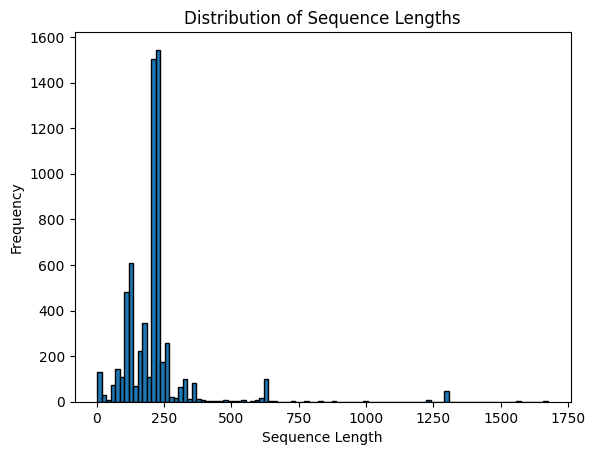

In [16]:
#Identify rough cutoff for sequence padding
import matplotlib.pyplot as plt

allen = []
for i in allfast:
    allen.append(len(allfast[i].seq))

# Plot histogram
plt.hist(allen, bins=100, edgecolor='black')

# Add labels and title
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')

# Show the plot
plt.show()

## ESM2

In [110]:
# Load ESM-2 model
#https://github.com/facebookresearch/esm#available-models
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
#model, alphabet = esm.pretrained.esm2_t30_150M_UR50D() #smaller model
batch_converter = alphabet.get_batch_converter()

In [46]:
trainlist

[('3MZW_1_338|A_3MZW_1_338|A_3MZW_2_338|B_vh',
  'TQVCTGTDMKLRLPASPETHLDMLRHLYQGCQVVQGNLELTYLPTNASLSFLQDIQEVQGYVLIAHNQVRQVPLQRLRIVRGTQLFEDNYALAVLDNGDPLNNTTPVTGASPGGLRELQLRSLTEILKGGVLIQRNPQLCYQDTILWKDIFHKNNQLALTLIDTNRSRACHPCSPMCKGSRCWGESSEDCQSLTRTVCAGGCARCKGPLPTDCCHEQCAAGCTGPKHSDCLACLHFNHSGICELHCPALVTYNTDTFESMPNPEGRYTFGASCVTACPYNYLSTDVGSCTLVCPLHNQEVTAEDGTQRCEKCSKPCARVCYGLGMEHLREVRAVTSANIQEFAGCKKIFGSLAFLPESFDGDPASNTAPLQPEQLQVFETLEEITGYLYISAWPDSLPDLSVFQNLQVIRGRILHNGAYSLTLQGLGISWLGLRSLRELGSGLALIHHNTHLCFVHTVPWDQLFRNPHQALLHTANRPEDECVGEGLACHQLCARGHCWGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYVNARHCLPCHPECQPQNGSVTCFGPEADQCVACAHYKDPPFCVARCPSGVKPDLSYMPIWKFPDEEGACQPCPINCTHSCVDLDDKGCPAEQ'),
 ('3MZW_1_338|A_3MZW_1_338|A_3MZW_2_338|B_vl',
  'TQVCTGTDMKLRLPASPETHLDMLRHLYQGCQVVQGNLELTYLPTNASLSFLQDIQEVQGYVLIAHNQVRQVPLQRLRIVRGTQLFEDNYALAVLDNGDPLNNTTPVTGASPGGLRELQLRSLTEILKGGVLIQRNPQLCYQDTILWKDIFHKNNQLALTLIDTNRSRACHPCSPMCKGSRCWGESSEDCQSLTRTVCAGGCARCKGPLPTDCCHEQCAAGCTGPKHSDCLACLHFNHSGICELHCPALVTYNTDTFESMPNPEGRYTFGAS

In [91]:
trainoutfold = mabdir+"/Embedding_esm2/train_800_nb/"
testoutfold = mabdir+"/Embedding_esm2/test_800_nb/"

start = time.time()
EmbeddingGeneration(trainlist, trainoutfold, model, batch_converter)
print(f"Train embeddings (total) = {round(time.time()-start, 3)} seconds")

start = time.time()
EmbeddingGeneration(testlist, testoutfold, model, batch_converter)
print(f"Train embeddings (total) = {round(time.time()-start, 3)} seconds")

Time taken (Embedding (batch 0)) = 0.5 seconds 	| Total (0.5)
Time taken (Embedding (batch 1)) = 0.44 seconds 	| Total (0.94)
Time taken (Embedding (batch 2)) = 0.44 seconds 	| Total (1.37)
Time taken (Embedding (batch 3)) = 0.43 seconds 	| Total (1.8)
Time taken (Embedding (batch 4)) = 0.43 seconds 	| Total (2.23)
Time taken (Embedding (batch 5)) = 0.43 seconds 	| Total (2.66)
Time taken (Embedding (batch 6)) = 0.43 seconds 	| Total (3.08)
Time taken (Embedding (batch 7)) = 0.43 seconds 	| Total (3.51)
Time taken (Embedding (batch 8)) = 0.43 seconds 	| Total (3.95)
Time taken (Embedding (batch 9)) = 0.43 seconds 	| Total (4.38)
Time taken (Embedding (batch 10)) = 0.43 seconds 	| Total (4.81)
Time taken (Embedding (batch 11)) = 0.43 seconds 	| Total (5.23)
Time taken (Embedding (batch 12)) = 0.43 seconds 	| Total (5.66)
Time taken (Embedding (batch 13)) = 0.43 seconds 	| Total (6.09)
Time taken (Embedding (batch 14)) = 0.43 seconds 	| Total (6.52)
Time taken (Embedding (batch 15)) = 0.

In [112]:
#outfold = mabdir+"/Embedding/"
#trainoutfold = mabdir+"/Embedding_esm2/train/"
#testoutfold = mabdir+"/Embedding_esm2/test/"

#trainoutfold = mabdir+"/Embedding_esm2/train_800/"
#testoutfold = mabdir+"/Embedding_esm2/test_800/"

trainoutfold = mabdir+"/Embedding_esm2/train_800_nb/"
testoutfold = mabdir+"/Embedding_esm2/test_800_nb/"

start = time.time()
train_embd = loadEmbd(train_df, trainoutfold, alldf)
print(f"Train embeddings (load) = {round(time.time()-start, 3)} seconds")
start = time.time()
test_embd  = loadEmbd(test_df, testoutfold, alldf)
print(f"Test embeddings (load) = {round(time.time()-start, 3)} seconds")
print(len(test_embd), len(train_embd))

Train embeddings (load) = 313.222 seconds
Test embeddings (load) = 53.993 seconds
392 1521


In [113]:
test_proc  = preprocess_dict(test_embd)
train_proc = preprocess_dict(train_embd)

train_dataset = AntibodyAffinityDataset2(train_proc)
test_dataset = AntibodyAffinityDataset2(test_proc)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [195]:
emb_dim = next(iter(train_proc.values()))[0].shape[1]  # get d from first VH
model = AffiniPredMulti(emb_dim)



model, train_all, test_all = trainModel(model, train_loader, test_loader, 100)

Epoch 01 | Train Loss: 94.9180 | Test Loss: 55.3928
Epoch 02 | Train Loss: 16.1993 | Test Loss: 9.3121
Epoch 03 | Train Loss: 7.9447 | Test Loss: 8.0123
Epoch 04 | Train Loss: 7.1829 | Test Loss: 6.5618
Epoch 05 | Train Loss: 6.0501 | Test Loss: 5.6633
Epoch 06 | Train Loss: 5.2391 | Test Loss: 5.0534
Epoch 07 | Train Loss: 4.8957 | Test Loss: 4.4771
Epoch 08 | Train Loss: 4.6511 | Test Loss: 4.1645
Epoch 09 | Train Loss: 4.5377 | Test Loss: 3.9753
Epoch 10 | Train Loss: 4.2785 | Test Loss: 3.8538
Epoch 11 | Train Loss: 4.1912 | Test Loss: 3.8071
Epoch 12 | Train Loss: 4.1748 | Test Loss: 3.7464
Epoch 13 | Train Loss: 4.2127 | Test Loss: 3.8163
Epoch 14 | Train Loss: 4.0992 | Test Loss: 3.8018
Epoch 15 | Train Loss: 4.1123 | Test Loss: 3.6511
Epoch 16 | Train Loss: 3.8590 | Test Loss: 3.7652
Epoch 17 | Train Loss: 3.9497 | Test Loss: 3.6052
Epoch 18 | Train Loss: 3.8822 | Test Loss: 3.5193
Epoch 19 | Train Loss: 3.7651 | Test Loss: 3.5365
Epoch 20 | Train Loss: 3.8813 | Test Loss: 3.50

In [191]:

def SanityCheck2(model, test_loader, label, test_loss, train_loss, miny, maxy):
    model.eval()
    y_true_list = []
    y_pred_list = []
    
    with torch.no_grad():
        for vh, vl, ag, y_true in test_loader:
            y_pred = model(vh, vl, ag)
            y_true_list.append(y_true.numpy())
            y_pred_list.append(y_pred.squeeze(1).numpy())
    
    import numpy as np
    y_true_all = np.concatenate(y_true_list)
    y_pred_all = np.concatenate(y_pred_list)
    
    from sklearn.metrics import mean_squared_error, r2_score
    from scipy.stats import pearsonr, spearmanr
    
    mse = mean_squared_error(y_true_all, y_pred_all)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_all, y_pred_all)
    pearson_r, _ = pearsonr(y_true_all, y_pred_all)
    spearman_r, _ = spearmanr(y_true_all, y_pred_all)
    
    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R²: {r2:.4f}")
    print(f"Test Pearson r: {pearson_r:.4f}")
    print(f"Test Spearman r: {spearman_r:.4f}")


    fig, plots = plt.subplots(nrows=1, ncols=2)
    
    #Affinity prediction plot
    plots[0].scatter(y_true_all, y_pred_all, alpha=0.4)
    plots[0].plot([y_true_all.min(), y_true_all.max()],
             [y_true_all.min(), y_true_all.max()],
             'r--')
    plots[0].set_xlabel(f'True {label} (affinity)')
    plots[0].set_ylabel(f"Predicted {label} (affinity)")
    plots[0].set_title("Affinity Prediction on Test")
    plots[0].grid(False)

    #Gradient descent loss plot
    plots[1].plot(train_loss, label="Train loss", linestyle='--')
    plots[1].plot(test_loss, label="Test loss", linestyle='--')
    plots[1].set_xlabel(f'Epoch')
    plots[1].set_ylabel(f"Averaged loss")
    plots[1].set_title("Training validation")
    plots[1].grid(False)
    plots[1].legend()
    plots[1].set_ylim(miny, maxy)
    fig.show()

    

Test MSE: 3.2525
Test RMSE: 1.8035
Test R²: 0.4972
Test Pearson r: 0.7138
Test Spearman r: 0.7355


/tmp/ipykernel_708504/1301996184.py:154: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


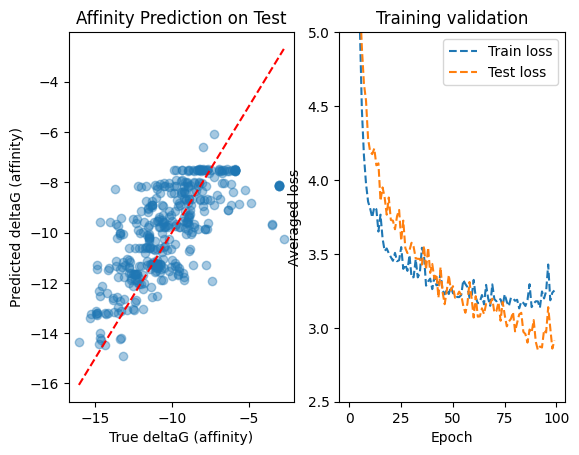

In [201]:
#Mixed mAb + nanobody (800 len), first
SanityCheck(model, test_loader, "deltaG", train_all, test_all, 2.5, 5)

Test MSE: 4.1957
Test RMSE: 2.0483
Test R²: 0.3648
Test Pearson r: 0.6314
Test Spearman r: 0.6195


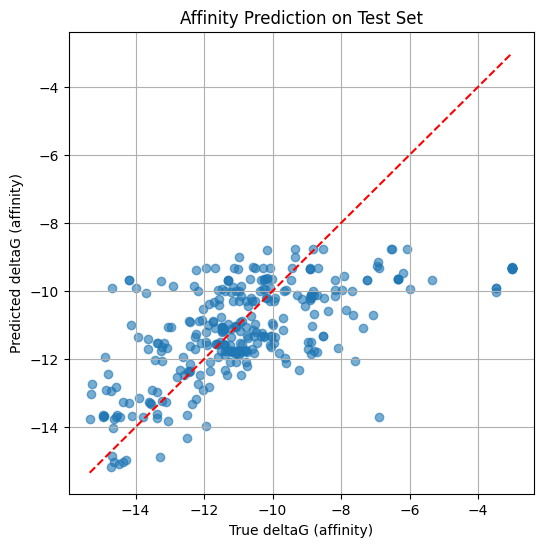

In [56]:
#First test (800 len)
SanityCheck(model, test_loader, "deltaG")

Test MSE: 4.0879
Test RMSE: 2.0219
Test R²: 0.2636
Test Pearson r: 0.5191
Test Spearman r: 0.5048


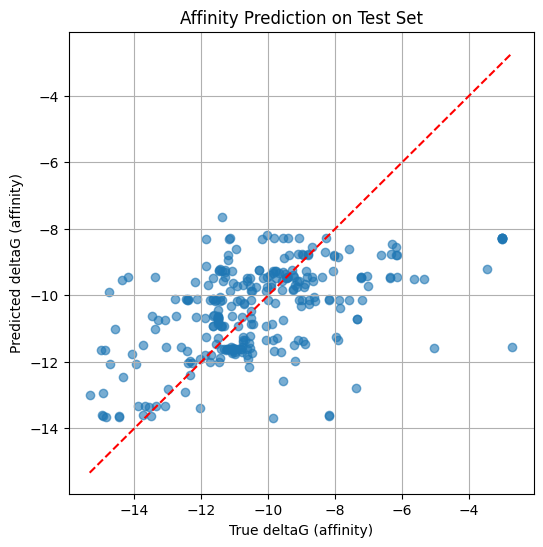

In [124]:
#Second test (500 len, includes nanobodies?)
SanityCheck(model, test_loader, "deltaG")

Test MSE: 3.1276
Test RMSE: 1.7685
Test R²: 0.4727
Test Pearson r: 0.6904
Test Spearman r: 0.7062


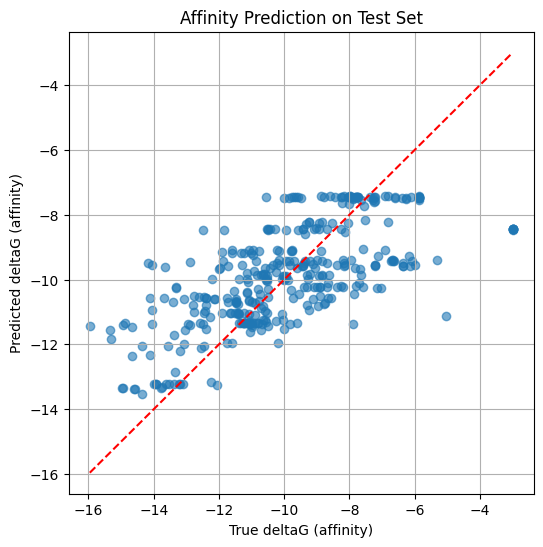

In [20]:
#First test (500 len)
SanityCheck(model, test_loader, "deltaG")

### Alt model - ProtBERT

In [27]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.8.0+cu128
12.8


In [86]:
import torchvision

In [97]:
import tqdm
from transformers import BertModel, BertTokenizer

# Load ProtBERT model + tokenizer
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
#model.eval()

In [89]:
def generate_protbert_embeddings(inputlist, outdir, model, tokenizer, batch_size=4):
    """
    Generate ProtBERT embeddings for tuples of (identifier, sequence).
    
    Each sequence is saved as {identifier}.pt in outdir.
    """
    os.makedirs(outdir, exist_ok=True)
    badseqs = []
    total = len(inputlist)
    print(f"Generating embeddings for {total} sequences...")

    start_global = time.time()
    model.eval()

    for i in range(0, total, batch_size):
        batch = inputlist[i:i+batch_size]
        ids = [sid for sid, seq in batch]
        seqs = [" ".join(list(seq)) for sid, seq in batch]  # ProtBERT expects spaced residues
        try:
            tokens = tokenizer(
                seqs,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=1024
            )
            tokens = {k: v.to(device) for k, v in tokens.items()}

            with torch.no_grad():
                outputs = model(**tokens)
                reps = outputs.last_hidden_state  # (B, L, 1024)

            for j, sid in enumerate(ids):
                length = int(tokens["attention_mask"][j].sum().item()) - 2  # exclude CLS + SEP
                emb = reps[j, 1:length+1, :].cpu()  # (L, 1024)

                outfile = os.path.join(outdir, f"{sid}.pt")
                torch.save(emb, outfile)

            print(f"[{i+len(batch)}/{total}] Batch done ({len(batch)} seqs)")

        except Exception as e:
            print(f"Error in batch starting at {i}: {e}")
            badseqs.extend(ids)
            torch.cuda.empty_cache()

    print(f"\n Done. Total time: {round(time.time()-start_global, 2)} s")
    if badseqs:
        print(f" Failed sequences: {badseqs}")
    return badseqs

trainoutfold = mabdir+"/Embedding_protBERT/train_800_nb/"
testoutfold = mabdir+"/Embedding_protBERT/test_800_nb/"

generate_protbert_embeddings(trainlist, trainoutfold, model, tokenizer, batch_size=10)
generate_protbert_embeddings(testlist, testoutfold, model, tokenizer, batch_size=10)

Generating embeddings for 4746 sequences...
[10/4746] Batch done (10 seqs)
[20/4746] Batch done (10 seqs)
[30/4746] Batch done (10 seqs)
[40/4746] Batch done (10 seqs)
[50/4746] Batch done (10 seqs)
[60/4746] Batch done (10 seqs)
[70/4746] Batch done (10 seqs)
[80/4746] Batch done (10 seqs)
[90/4746] Batch done (10 seqs)
[100/4746] Batch done (10 seqs)
[110/4746] Batch done (10 seqs)
[120/4746] Batch done (10 seqs)
[130/4746] Batch done (10 seqs)
[140/4746] Batch done (10 seqs)
[150/4746] Batch done (10 seqs)
[160/4746] Batch done (10 seqs)
[170/4746] Batch done (10 seqs)
[180/4746] Batch done (10 seqs)
[190/4746] Batch done (10 seqs)
[200/4746] Batch done (10 seqs)
[210/4746] Batch done (10 seqs)
[220/4746] Batch done (10 seqs)
[230/4746] Batch done (10 seqs)
[240/4746] Batch done (10 seqs)
[250/4746] Batch done (10 seqs)
[260/4746] Batch done (10 seqs)
[270/4746] Batch done (10 seqs)
[280/4746] Batch done (10 seqs)
[290/4746] Batch done (10 seqs)
[300/4746] Batch done (10 seqs)
[310/

[]

In [98]:
#trainoutfold = mabdir+"/Embedding_protBERT/train/"
#testoutfold = mabdir+"/Embedding_protBERT/test/"

#trainoutfold = mabdir+"/Embedding_protBERT/train_800/"
#testoutfold = mabdir+"/Embedding_protBERT/test_800/"

trainoutfold = mabdir+"/Embedding_protBERT/train_800_nb/"
testoutfold = mabdir+"/Embedding_protBERT/test_800_nb/"

start = time.time()
train_embd = loadEmbd(train_df, trainoutfold, alldf)
print(f"Train embeddings (load) = {round(time.time()-start, 3)} seconds")
start = time.time()
test_embd  = loadEmbd(test_df, testoutfold, alldf)
print(f"Test embeddings (load) = {round(time.time()-start, 3)} seconds")
print(len(test_embd), len(train_embd))

Train embeddings (load) = 211.569 seconds
Test embeddings (load) = 52.632 seconds
392 1521


In [99]:
train_proc = preprocess_dict(train_embd)
test_proc  = preprocess_dict(test_embd)

train_dataset = AntibodyAffinityDataset2(train_proc)
test_dataset = AntibodyAffinityDataset2(test_proc)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [105]:
train_dataset[0]

(tensor([ 0.0994,  0.0690, -0.0416,  ..., -0.0553, -0.0563, -0.0003]),
 tensor([ 0.1251,  0.0781,  0.0016,  ..., -0.0861, -0.0940, -0.0115]),
 tensor([-0.0084,  0.0264, -0.0297,  ...,  0.0510,  0.0351, -0.0242]),
 tensor(-10.9000))

In [102]:
emb_dim = next(iter(train_proc.values()))[0].shape[1]  # get d from first VH
model = AffiniPredMulti(emb_dim)

import torch.nn as nn
import torch.optim as optim
def trainModel(model, train_loader, test_loader):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    for epoch in range(50):
        model.train()
        total_loss = 0.0
        for vh, vl, ag, y in train_loader:
            print(vh.size(), vl.size(), ag.size(), y.size())
            optimizer.zero_grad()
            pred = model(vh, vl, ag)
            loss = criterion(pred, y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * vh.size(0)
    
        avg_loss = total_loss / len(train_loader.dataset)
    
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for vh, vl, ag, y in test_loader:
                pred = model(vh, vl, ag)
                loss = criterion(pred, y.unsqueeze(1))
                test_loss += loss.item() * vh.size(0)
    
        test_loss /= len(test_loader.dataset)
        print(test_loss)
        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_loss:.4f} | Test Loss: {test_loss:.4f}")

    return model

model = trainModel(model, train_loader, test_loader)

RuntimeError: stack expects each tensor to be equal size, but got [1024] at entry 0 and [] at entry 3

In [106]:
for vh, vl, ag, y in train_loader:
    print(vh.size(), vl.size(), ag.size(), y.size())

RuntimeError: stack expects each tensor to be equal size, but got [1024] at entry 0 and [] at entry 2

In [ ]:
#Mixed mAb + nanobody (800 len), first
SanityCheck(model, test_loader, "deltaG")

Test MSE: 4.0957
Test RMSE: 2.0238
Test R²: 0.3799
Test Pearson r: 0.6203
Test Spearman r: 0.6014


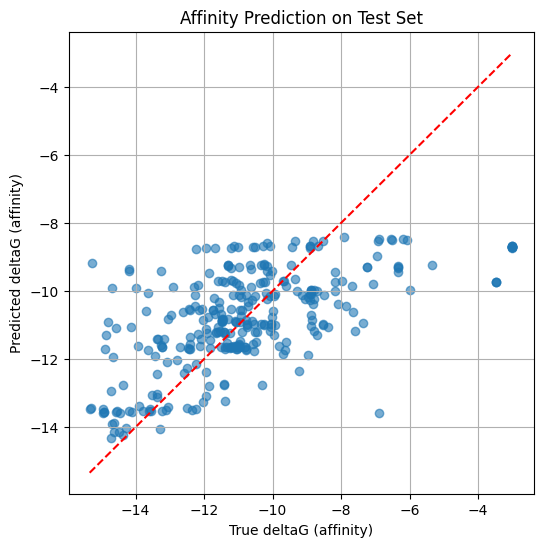

In [61]:
#First test (800 len)
SanityCheck(model, test_loader, "deltaG")

Test MSE: 3.6247
Test RMSE: 1.9039
Test R²: 0.3471
Test Pearson r: 0.5914
Test Spearman r: 0.5843


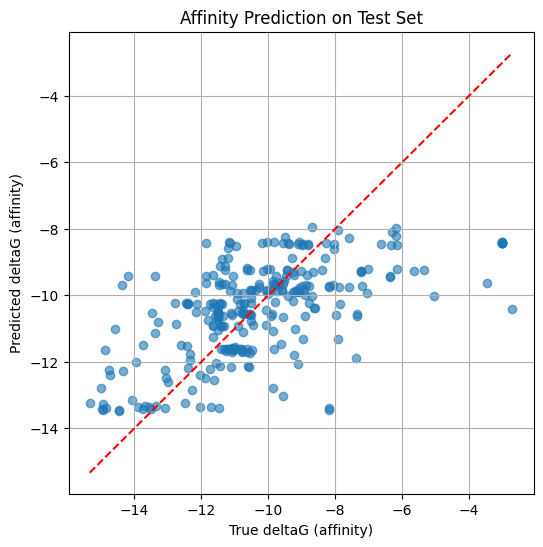

In [129]:
#First test (500 len)
SanityCheck(model, test_loader, "deltaG")

## SAbDab

In [296]:
#mabfolder = datadir+"/Sabdab/20250928_0394629"
#sumdf = pd.read_csv(mabfolder+"/20250928_0394629_summary.tsv", sep="\t")

mabfolder = datadir+"/Sabdab/20250929_0515375"
sumdf = pd.read_csv(mabfolder+"/20250929_0515375_summary.tsv", sep="\t")

records = []

parser = PDBParser(QUIET=True)
ppb = PPBuilder()

start = time.time()
for fname in os.listdir(mabfolder):
    if fname.endswith(".pdb"):
        pdb_id = fname.split('.')[0]
        structure = parser.get_structure(pdb_id, os.path.join(mabfolder, fname))
        vh_seq = None
        vl_seq = None 
        ag_seq = []
        #Iterate over chains in pdb, retrieve seq, append to obj based on summary file annotation
        for chain in structure.get_chains():
            curid = chain.full_id
            row = sumdf.loc[sumdf["pdb"] == chain.full_id[0]]
            seq = "".join([str(pp.get_sequence()) for pp in ppb.build_peptides(chain)])
            hchains = row["Hchain"].values
            lchains = row["Lchain"].values
            if curid[2] in hchains:
                vh_seq = seq
            elif curid[2] in lchains:
                vl_seq = seq
            else:
                if seq not in ag_seq:
                    ag_seq.append(seq)
        #If all seqs identified, append to records obj for df generation
        if vh_seq and vl_seq and ag_seq:
            records.append({
                "pdb_id": pdb_id,
                "vh_seq": vh_seq,
                "vl_seq": vl_seq,
                "antigen": ag_seq[0]
                })

alldf = pd.DataFrame(records)
display(alldf)

print(f"PDB read-in complete = {round(time.time()-start, 3)} seconds")

,pdb_id,vh_seq,vl_seq,antigen
0,4kro,QVQLKQSGPGLVQPSQSLSITCTVSGFSLTNYGVHWVRQSPGKGLE...,DILLTQSPVILSVSPGERVSFSCRASQSIGTNIHWYQQRTNGSPRL...,KKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRN...
1,3ghe,QVQLVQSGGGLVQPGGSLRLSCVASGFTFNNYWMSWVRQAPGKGLE...,QSALTQPASVSGSPGQSITISCTGTSTDVNGYNYVSWYQQYAGKAP...,RKRIHIGPGRAFYAT
2,2ny4,EVQLVESGAEVKKPGSSVKVSCKASGDTFIRYSFTWVRQAPGQGLE...,DIVMTQSPATLSVSPGERATLSCRASESVSSDLAWYQQKPGQAPRL...,EVVLVNVTENFNMWKNDMVEQMHEDIISLWDQSLKPCVKLTPLCVG...
3,3lev,RITLKESGPPLVKPTQTLTLTCSFSGFSLSDFGVGVGWIRQPPGKA...,ALQLTQSPSSLSASVGDRITITCRASQGVTSALAWYRQKPGSPPQL...,SDPVRQYLHEIGEVLELDKWAELGAAAKVEEGMEAIKKLSEATGLD...
4,3ru8,QVQLVQSGAEVKKPGASVKVSCQASGYRFSNFVIHWVRQAPGQRFE...,EIVLTQSPGTLSLSPGERATFSCRSSHSIRSRRVAWYQHKPGQAPR...,DSPFYVNPNMSSAEWVRNNPNDPRTPVIRNRIASVPQGTWHNQHNP...
...,...,...,...,...
531,1jrh,AVKLQESGPGILKPSQTLSLTCSFSGFSLTTYGMGVGWIRQSSGKG...,SVEMTQSPSSFSVSLGDRVTITCKASEDIYNRLAWYQQKPGNAPRL...,SVPTPTNVTIESYNMNPIVYWEYQIMPQVPVFTVEVKNYGVKNSEW...
532,3eyf,QVRLVESGGGVVQPGGSLRLSCEGSGFKFGDHGIHWVRQAPGEGLQ...,MEIVLTQSPATLSLSPGERATLSCRASQSVGGYLTWYQHKPGQAPR...,TIYNTTLKY
533,4gw1,QVQLKQSGPGLVQPSQSLSITCTVSGFSLTNYGVHWVRQSPGKGLE...,DILLTQSPVILSVSPGERVSFSCRASQSIGTNIHWYQQRTNGSPRL...,CQFDLSTRRLKC
534,3e8u,QIQLVQSGPELRKPGETVKISCKGSGYTFTHYGINWVKQTPSKDLK...,DNVLTQSPPSLAVSLGQRATISCKASQSVDYNGDSYLNWYQQKPGQ...,GVQGSGAFGRG


PDB read-in complete = 38.163 seconds


In [221]:
# Load ESM-2 model
#https://github.com/facebookresearch/esm#available-models
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
#model, alphabet = esm.pretrained.esm2_t30_150M_UR50D() #smaller model
batch_converter = alphabet.get_batch_converter()

In [222]:
#Split to test + train datasets
train_df, test_df = train_test_split(alldf, 
                                    test_size=0.2,
                                    random_state=42, 
                                    shuffle=True)

#Prepare sequences for tokenisation
trainlist = []
for i, row in train_df.iterrows():
    row["pdb_id"]
    trainlist.append((row["pdb_id"]+"_vh", row["vh_seq"]))
    trainlist.append((row["pdb_id"]+"_vl", row["vl_seq"]))
    trainlist.append((row["pdb_id"]+"_ag", row["antigen"]))

testlist = []
for i, row in test_df.iterrows():
    row["pdb_id"]
    testlist.append((row["pdb_id"]+"_vh", row["vh_seq"]))
    testlist.append((row["pdb_id"]+"_vl", row["vl_seq"]))
    testlist.append((row["pdb_id"]+"_ag", row["antigen"]))



[('4hkx_vh', 'QVQLVQSGAEVRKPGASVKVSCKASGYTFTDNYIHWVRQAPGQGLEWMGWIHPNSGATKYAQKFEGWVTMTRDTSISTVYMELSRSRSDDTAVYYCARAGLEPRSVDYYFYGLDVWGQGTAVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKRVEP'), ('4hkx_vl', 'QSALTQPPSVSVAPGQTATITCGGNNIGRKRVDWFQQKPGQAPVLVVYERFSDSNSGTTATLTISRVEAGDEADYYCQVWDSDSDHVVFGGGTKLTVLGQPKAAPSVTLFPPSSEELQANKATLVCLISDFYPGAVTVAWKADSSPVKAGVETTTPSKQSNNKYAASSYLSLTPEQWKSHRSYSCQVTHEGSTVEKTVAPT'), ('4hkx_ag', 'APLQLGNCSVAGWILGNPECELLISRESWSYIVEKPNPENGTCYPGHFADYEELREQLSSVSSFERFEIFPKESSWPNHTTTGVSASCSHNGESSFYKNLLWLTGKNGLYPNLSKSYANNKEKEVLVLWGVHHPPNIGDQRALYHTENAYVSVVSSHYSRKFTPEIAKRPKVRDQEGRINYYWTLLEPGDTIIFEANGNLIAPRYAFALSRG'), ('4wht_vh', 'VKLQESGGGLVQPGRSLKLSCAASGFTFSDSYLAWVRQAPTKGLEWVASITNSGGRFYYRDSVKGRFTISRDNAKSTLYLQMDSLRSEDTATYYCTRMDYWGQGTTVTVSSAETTAPSVYPLAPGTASMVTLGCLVKGYFPEPVTVTWNSGALSSGVHTFPAVLQSGLYTLTSSVTVPSTVTCNVAHPASSTKVDKKIV'), ('4wht_vl', 'DIVLTQTTPTLSATIGQSVSISCRSSQSLLESDGNTYLNWLLQRPGQSPQLLIYSVSNLESGVPNRFSGSGSETDFTLKI

In [223]:
outfold = mabfolder+"/Embedding/"
start = time.time()
EmbeddingGeneration(trainlist, outfold, model, batch_converter)
print(f"Train embeddings (total) = {round(time.time()-start, 3)} seconds")

start = time.time()
EmbeddingGeneration(testlist, outfold, model, batch_converter)
print(f"Train embeddings (total) = {round(time.time()-start, 3)} seconds")

Time taken (Embedding (batch 0)) = 1.29 seconds 	| Total (1.29)
Time taken (Embedding (batch 1)) = 1.1 seconds 	| Total (2.4)
Time taken (Embedding (batch 2)) = 1.12 seconds 	| Total (3.51)
Time taken (Embedding (batch 3)) = 1.1 seconds 	| Total (4.61)
Time taken (Embedding (batch 4)) = 1.1 seconds 	| Total (5.71)
Time taken (Embedding (batch 5)) = 1.1 seconds 	| Total (6.81)
Time taken (Embedding (batch 6)) = 1.1 seconds 	| Total (7.91)
Time taken (Embedding (batch 7)) = 1.1 seconds 	| Total (9.0)
Time taken (Embedding (batch 8)) = 1.1 seconds 	| Total (10.11)
Time taken (Embedding (batch 9)) = 1.1 seconds 	| Total (11.21)
Time taken (Embedding (batch 10)) = 1.1 seconds 	| Total (12.31)
Time taken (Embedding (batch 11)) = 1.1 seconds 	| Total (13.41)
Time taken (Embedding (batch 12)) = 1.1 seconds 	| Total (14.51)
Time taken (Embedding (batch 13)) = 1.1 seconds 	| Total (15.61)
Time taken (Embedding (batch 14)) = 1.1 seconds 	| Total (16.71)
Time taken (Embedding (batch 15)) = 1.1 sec

In [230]:
outfold = mabfolder+"/Embedding/"

start = time.time()
train_embd = loadEmbd(train_df, outfold, sumdf)
print(f"Train embeddings (load) = {round(time.time()-start, 3)} seconds")
start = time.time()
test_embd  = loadEmbd(test_df, outfold, sumdf)
print(f"Test embeddings (load) = {round(time.time()-start, 3)} seconds")
print(len(test_embd), len(train_embd))

/tmp/ipykernel_6772/2980635524.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embd_vh = torch.load(f'{outfold}{row["pdb_id"]}_vh.pt')
/tmp/ipykernel_6772/2980635524.py

3e-06 False
1e-10 False
0.0002 False
9.4e-08 False
4.6e-08 False
3.4e-06 False
1e-05 False
8.3e-07 False
5e-07 False
4e-06 False
7.5e-12 False
1.1e-10 False
1.58e-08 False
8.1e-10 False
2.69e-10 False
5.29e-07 False
1e-07 False
4.1e-08 False
7.69e-09 False
6e-10 False
2.9e-08 False
2.6e-08 False
1.3e-09 False
1.4e-10 False
1.4e-08 False
2.73e-06 False
4.35e-07 False
4.97e-09 False
1e-09 False
1.92e-09 False
5.45e-08 False
1.7e-08 False
1.5e-07 False
6e-10 False
7.8e-09 False
4e-06 False
2.1e-09 False
1e-10 False
4.4e-09 False
1.4e-11 False
4.9e-11 False
8.7e-09 False
1.4e-08 False
2.41e-07 False
1.3e-09 False
1.14e-10 False
1.2e-08 False
2e-10 False
1.47e-06 False
2.5e-10 False
3.3e-09 False
4e-12 False
2.5e-09 False
6.8e-12 False
3e-07 False
7.7e-09 False
9.8e-11 False
3.4e-09 False
2.55e-09 False
6.24e-09 False
5.4e-11 False
1.1e-10 False
3.1e-07 False
8.15e-07 False
3.3e-09 False
2.2e-08 False
1.4e-08 False
1e-09 False
9.1e-08 False
3.98e-08 False
3e-08 False
5.2e-11 False
8.5e-08 F

In [206]:
print(test_embd["2w9e"][0].shape)

torch.Size([1, 536, 1280])


In [247]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

def preprocess_dict(raw_dict):
    processed = {}
    for pdb_id, (vh, vl, ag, aff) in raw_dict.items():
        vh = vh.squeeze(0)  # remove batch dim → (L_vh, d)
        vl = vl.squeeze(0)
        ag = ag.squeeze(0)
        processed[pdb_id] = (vh, vl, ag, float(aff))
    return processed

def mean_pool(t):
    return t.mean(dim=0)  # (L, d) → (d,)

class AntibodyAffinityDataset(Dataset):
    def __init__(self, data_dict, pool_fn=mean_pool):
        self.items = list(data_dict.items())
        self.pool_fn = pool_fn

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        pdb_id, (vh, vl, ag, y) = self.items[idx]
        vh_vec = self.pool_fn(vh)
        vl_vec = self.pool_fn(vl)
        ag_vec = self.pool_fn(ag)
        y_val = torch.tensor(np.log10(y), dtype=torch.float32)
        return vh_vec, vl_vec, ag_vec, y_val


test_proc  = preprocess_dict(test_embd)
train_proc = preprocess_dict(train_embd)

train_dataset = AntibodyAffinityDataset(train_proc)
test_dataset = AntibodyAffinityDataset(test_proc)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [254]:
import torch.nn as nn

class AffiniPredMulti(nn.Module):
    def __init__(self, emb_dim, hidden_dim=256, fusion_dim=128):
        super().__init__()
        # Indiv branch analysis
        self.seq = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, fusion_dim),
            nn.ReLU()
        )
        # Fusion & regression head
        self.reg_head = nn.Sequential(
            nn.Linear(fusion_dim * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, vh, vl, ag):
        vh_latent = self.seq(vh)
        vl_latent = self.seq(vl)
        ag_latent = self.seq(ag)

        fused = torch.cat([vh_latent, vl_latent, ag_latent], dim=1)
        out = self.reg_head(fused)
        return out

In [257]:
emb_dim = next(iter(train_proc.values()))[0].shape[1]  # get d from first VH
model = AffiniPredMulti(emb_dim)

import torch.nn as nn
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(30):
    model.train()
    total_loss = 0.0
    for vh, vl, ag, y in train_loader:
        optimizer.zero_grad()
        pred = model(vh, vl, ag)
        loss = criterion(pred, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * vh.size(0)

    avg_loss = total_loss / len(train_loader.dataset)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for vh, vl, ag, y in test_loader:
            pred = model(vh, vl, ag)
            loss = criterion(pred, y.unsqueeze(1))
            test_loss += loss.item() * vh.size(0)

    test_loss /= len(test_loader.dataset)
    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_loss:.4f} | Test Loss: {test_loss:.4f}")


Epoch 01 | Train Loss: 65.5029 | Test Loss: 66.4751
Epoch 02 | Train Loss: 64.5300 | Test Loss: 65.4137
Epoch 03 | Train Loss: 63.3925 | Test Loss: 64.1005
Epoch 04 | Train Loss: 61.9321 | Test Loss: 62.3407
Epoch 05 | Train Loss: 59.9613 | Test Loss: 59.8790
Epoch 06 | Train Loss: 57.3965 | Test Loss: 56.5021
Epoch 07 | Train Loss: 53.2577 | Test Loss: 51.9443
Epoch 08 | Train Loss: 48.1411 | Test Loss: 45.8019
Epoch 09 | Train Loss: 41.8122 | Test Loss: 37.8850
Epoch 10 | Train Loss: 33.2654 | Test Loss: 28.3986
Epoch 11 | Train Loss: 23.6783 | Test Loss: 18.2348
Epoch 12 | Train Loss: 13.8882 | Test Loss: 9.0990
Epoch 13 | Train Loss: 6.0201 | Test Loss: 3.4602
Epoch 14 | Train Loss: 2.9365 | Test Loss: 2.5113
Epoch 15 | Train Loss: 3.0667 | Test Loss: 2.9746
Epoch 16 | Train Loss: 3.4693 | Test Loss: 2.5994
Epoch 17 | Train Loss: 3.0023 | Test Loss: 2.4564
Epoch 18 | Train Loss: 2.3397 | Test Loss: 2.6521
Epoch 19 | Train Loss: 2.5755 | Test Loss: 2.6870
Epoch 20 | Train Loss: 2.51

In [258]:
import torch

model.eval()
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for vh, vl, ag, y_true in test_loader:
        y_pred = model(vh, vl, ag)
        y_true_list.append(y_true.numpy())
        y_pred_list.append(y_pred.squeeze(1).numpy())

import numpy as np
y_true_all = np.concatenate(y_true_list)
y_pred_all = np.concatenate(y_pred_list)

from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

mse = mean_squared_error(y_true_all, y_pred_all)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_all, y_pred_all)
pearson_r, _ = pearsonr(y_true_all, y_pred_all)
spearman_r, _ = spearmanr(y_true_all, y_pred_all)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")
print(f"Test Pearson r: {pearson_r:.4f}")
print(f"Test Spearman r: {spearman_r:.4f}")



Test MSE: 2.8330
Test RMSE: 1.6832
Test R²: -0.2775
Test Pearson r: 0.0355
Test Spearman r: 0.1992


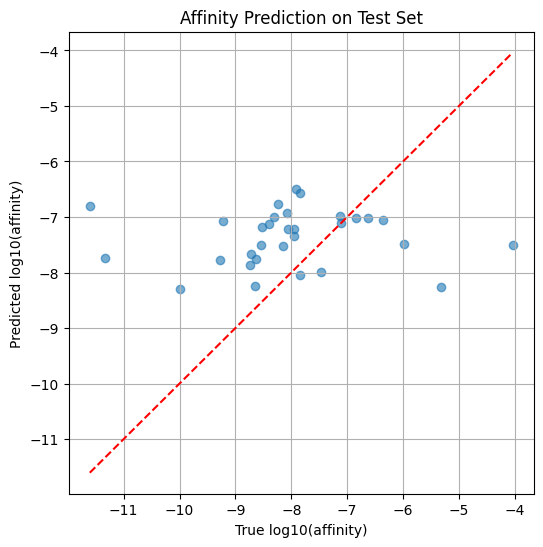

In [259]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true_all, y_pred_all, alpha=0.6)
plt.plot([y_true_all.min(), y_true_all.max()],
         [y_true_all.min(), y_true_all.max()],
         'r--')
plt.xlabel("True log10(affinity)")
plt.ylabel("Predicted log10(affinity)")
plt.title("Affinity Prediction on Test Set")
plt.grid(True)
plt.show()


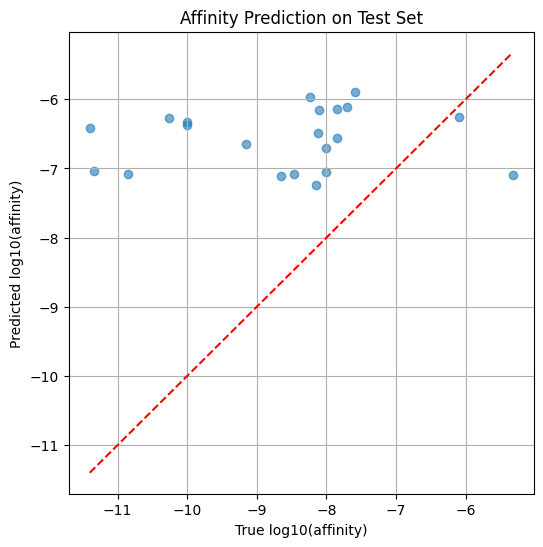

In [218]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true_all, y_pred_all, alpha=0.6)
plt.plot([y_true_all.min(), y_true_all.max()],
         [y_true_all.min(), y_true_all.max()],
         'r--')
plt.xlabel("True log10(affinity)")
plt.ylabel("Predicted log10(affinity)")
plt.title("Affinity Prediction on Test Set")
plt.grid(True)
plt.show()


## BindingDB

In [2]:
bindf = pd.read_csv(datadir+"/BindingDB/BindingDB_BindingDB_Articles.tsv", sep='\t', low_memory=False, on_bad_lines='skip')

In [5]:
display(bindf[0:50])

,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,Proto-oncogene tyrosine-protein kinase Src.1,SRC_HUMAN,P12931,E1P5V4 Q76P87 Q86VB9 Q9H5A8,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102
0,9826,COc1cc2c(Nc3cc(OC)c(OC)c(OC)c3)c(cnc2cc1OCCCN1...,InChI=1S/C28H35N5O5/c1-32-8-10-33(11-9-32)7-6-...,VOUVVBUKNLBXGS-UHFFFAOYSA-N,6121,6-methoxy-7-[3-(4-methylpiperazin-1-yl)propoxy...,Proto-oncogene tyrosine-protein kinase Src,Homo sapiens,NaN,5.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9827,COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(Cl)cc3Cl)c2cc1O...,InChI=1S/C23H23Cl2N3O5/c1-29-4-6-32-21-8-15-18...,VXEOIAFZWQMOEP-UHFFFAOYSA-N,6122,"4-[(2,4-dichloro-5-methoxyphenyl)amino]-6,7-bi...",Proto-oncogene tyrosine-protein kinase Src,Homo sapiens,NaN,2.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9828,COCCOc1cc2ncc(C#N)c(Nc3ccc(Cl)cc3Cl)c2cc1OCCOC,InChI=1S/C22H21Cl2N3O4/c1-28-5-7-30-20-10-16-1...,DTLASHUZTAPRBX-UHFFFAOYSA-N,6123,"4-[(2,4-dichlorophenyl)amino]-6,7-bis(2-methox...",Proto-oncogene tyrosine-protein kinase Src,Homo sapiens,NaN,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9829,COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(OC)c(OC)c3)c2cc...,InChI=1S/C25H29N3O7/c1-29-6-8-34-20-12-18-19(1...,BTBPPLGKNLXRGR-UHFFFAOYSA-N,6124,"6,7-bis(2-methoxyethoxy)-4-[(3,4,5-trimethoxyp...",Proto-oncogene tyrosine-protein kinase Src,Homo sapiens,NaN,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9830,COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(Cl)cc3Cl)c2cc1OC,InChI=1S/C21H19Cl2N3O4/c1-27-4-5-30-20-8-16-13...,RFMNZXCDCPAELC-UHFFFAOYSA-N,6125,"4-[(2,4-dichloro-5-methoxyphenyl)amino]-6-meth...",Proto-oncogene tyrosine-protein kinase Src,Homo sapiens,NaN,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,9831,COCCOc1cc2ncc(C#N)c(Nc3ccc(Cl)cc3Cl)c2cc1OC,InChI=1S/C20H17Cl2N3O3/c1-26-5-6-28-19-9-17-14...,JAFCVKPQAMVADP-UHFFFAOYSA-N,6126,"4-[(2,4-dichlorophenyl)amino]-6-methoxy-7-(2-m...",Proto-oncogene tyrosine-protein kinase Src,Homo sapiens,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,9832,COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(OC)c(OC)c3)c2cc1OC,InChI=1S/C23H25N3O6/c1-27-6-7-32-19-11-17-16(1...,CEWSFUURKWZZLP-UHFFFAOYSA-N,6127,"6-methoxy-7-(2-methoxyethoxy)-4-[(3,4,5-trimet...",Proto-oncogene tyrosine-protein kinase Src,Homo sapiens,NaN,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9833,COc1cc(Nc2c(cnc3cc(OCC4CCN(C)CC4)c(OC)cc23)C#N...,InChI=1S/C25H26Cl2N4O3/c1-31-6-4-15(5-7-31)14-...,TXAYKQMEBQBGLR-UHFFFAOYSA-N,6094,"3-quinolinecarbonitrile 18::4-[(2,4-dichloro-5...",Proto-oncogene tyrosine-protein kinase Src,Homo sapiens,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9834,COc1cc2c(Nc3ccc(Cl)cc3Cl)c(cnc2cc1OCC1CCN(C)CC...,InChI=1S/C24H24Cl2N4O2/c1-30-7-5-15(6-8-30)14-...,ONVKFNZGEFTWQD-UHFFFAOYSA-N,6100,"3-quinolinecarbonitrile 19::4-[(2,4-Dichloroph...",Proto-oncogene tyrosine-protein kinase Src,Homo sapiens,NaN,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9835,COc1cc2c(Nc3cc(OC)c(OC)c(OC)c3)c(cnc2cc1OCC1CC...,InChI=1S/C27H32N4O5/c1-31-8-6-17(7-9-31)16-36-...,BWLSIYJKVFXNFV-UHFFFAOYSA-N,6101,3-quinolinecarbonitrile 20::6-Methoxy-7-[(1-me...,Proto-oncogene tyrosine-protein kinase Src,Homo sapiens,NaN,8.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
for i in bindf.columns:
    print(i)

BindingDB Reactant_set_id
Ligand SMILES
Ligand InChI
Ligand InChI Key
BindingDB MonomerID
BindingDB Ligand Name
Target Name
Target Source Organism According to Curator or DataSource
Ki (nM)
IC50 (nM)
Kd (nM)
EC50 (nM)
kon (M-1-s-1)
koff (s-1)
pH
Temp (C)
Curation/DataSource
Article DOI
BindingDB Entry DOI
PMID
PubChem AID
Patent Number
Authors
Date of publication
Date in BindingDB
Institution
Link to Ligand in BindingDB
Link to Target in BindingDB
Link to Ligand-Target Pair in BindingDB
Ligand HET ID in PDB
PDB ID(s) for Ligand-Target Complex
PubChem CID
PubChem SID
ChEBI ID of Ligand
ChEMBL ID of Ligand
DrugBank ID of Ligand
IUPHAR_GRAC ID of Ligand
KEGG ID of Ligand
ZINC ID of Ligand
Number of Protein Chains in Target (>1 implies a multichain complex)
BindingDB Target Chain Sequence
PDB ID(s) of Target Chain
UniProt (SwissProt) Recommended Name of Target Chain
UniProt (SwissProt) Entry Name of Target Chain
UniProt (SwissProt) Primary ID of Target Chain
UniProt (SwissProt) Secondary I

In [ ]:
for i in 

In [6]:
bindf.loc[bindf["BindingDB Reactant_set_id"] == 9829]

,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,Proto-oncogene tyrosine-protein kinase Src.1,SRC_HUMAN,P12931,E1P5V4 Q76P87 Q86VB9 Q9H5A8,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102
3,9829,COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(OC)c(OC)c3)c2cc...,InChI=1S/C25H29N3O7/c1-29-6-8-34-20-12-18-19(1...,BTBPPLGKNLXRGR-UHFFFAOYSA-N,6124,"6,7-bis(2-methoxyethoxy)-4-[(3,4,5-trimethoxyp...",Proto-oncogene tyrosine-protein kinase Src,Homo sapiens,NaN,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
bindf["BindingDB Ligand Name"].values

array(['6-methoxy-7-[3-(4-methylpiperazin-1-yl)propoxy]-4-[(3,4,5-trimethoxyphenyl)amino]quinoline-3-carbonitrile::3-quinolinecarbonitrile 4',
       '4-[(2,4-dichloro-5-methoxyphenyl)amino]-6,7-bis(2-methoxyethoxy)quinoline-3-carbonitrile::3-quinolinecarbonitrile 8',
       '4-[(2,4-dichlorophenyl)amino]-6,7-bis(2-methoxyethoxy)quinoline-3-carbonitrile::3-quinolinecarbonitrile 9',
       ...,
       'Analog of 14-(Arylhydroxyamino)codeinone::4-methyl-(1S,5R,13R,14S,17R)-12-oxa-4-azapentacyclo[9.6.1.01,13.05,17.07,18]octadeca-7(18),8,10,15-tetraene-10,14-diol(morphine)::4-methyl-12-oxa-4-azapentacyclo[9.6.1.01,13.05,17.07,18]octadeca-7(18),8,10,15-tetraene-10,14-diol::4-methyl-12-oxa-4-azapentacyclo[9.6.1.01,13.05,17.07,18]octadeca-7(18),8,10,15-tetraene-10,14-diol (morphine)::4-methyl-(1S,5R,13R,14S,17R)-12-oxa-4-azapentacyclo[9.6.1.01,13.05,17.07,18]octadeca-7(18),8,10,15-tetraene-10,14-diol::2-{4-[2,4-diamino-6-pteridinylmethyl(methyl)amino]phenylcarboxamido}pentanedioic acid(morphi